In [356]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from WindPy import w
from sklearn import linear_model, ensemble, svm
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
ldf = pd.read_excel('D:/workspace/crusader/data/list.xlsx')
ldf = ldf.dropna().set_index(u'代码')

In [4]:
DATA_DIR = 'D:/Data/industry/'
industry = [x for x in os.listdir(DATA_DIR)]

In [5]:
df = ''
for ind in industry:
    files = [f for f in os.listdir('%s/%s'%(DATA_DIR, ind))]
    for f in files:
        fname = '%s/%s/%s'%(DATA_DIR, ind, f)
        if not isinstance(df, pd.DataFrame):
            df = pd.read_excel(fname)
        else:
            tdf = pd.read_excel(fname)
            cols = tdf.columns.difference(df.columns)
            df = df.merge(tdf[cols], how='outer', left_index=True, right_index=True)

In [6]:
df = df.fillna(method='ffill').resample('BM').last()

In [7]:
df = df[(df.index >= '2004-01-01') & (df.index <= '2018-02-28')]

In [8]:
df = df.dropna(axis=1)

In [9]:
df.shape

(170, 114)

In [10]:
df.tail()

,M0000617,M0000616,M0000622,M5462042,S0109326,M0000612,S0109328,S0031749,S0037083,S0039170,...,S0030518,S0000066,M0067855,S0030509,S0030512,M0000545,S0035972,S0030503,S0030527,S0030515
2017-10-31,1.6284,-0.4,0.3174,1510.086,13920.4,1.9,44425.8,61623.9,113034.48,68501.96,...,8.0,775.54,6.6272,0.8,5.6,6.2,13.0,8.9,5.8,1.7
2017-11-30,1.4963,-1.1,-9.4797,1510.086,13920.4,1.7,44425.8,61623.9,113034.48,68501.96,...,8.2,785.20,6.6107,0.8,4.5,6.1,13.3,8.7,5.5,1.6
2017-12-29,1.4963,-1.1,-9.4797,1510.086,13920.4,1.7,44425.8,61623.9,113034.48,68501.96,...,8.2,770.64,6.5120,0.8,4.5,6.1,13.3,8.7,5.5,1.6
2018-01-31,1.3000,-0.4,-8.6000,1510.086,14031.5,1.8,44585.2,61623.9,112219.60,68501.96,...,2.6,819.59,6.2920,1.4,12.3,6.2,5.5,8.7,0.2,0.3
2018-02-28,1.3000,-0.4,-8.6000,1510.086,14031.5,1.8,44585.2,61623.9,112219.60,68501.96,...,2.6,848.32,6.3335,1.4,12.3,6.2,5.5,8.7,0.2,0.3


In [12]:
INDEX_DIR = 'D:/Data/index'

In [13]:
dic = {}
for f in os.listdir(INDEX_DIR):
    if f.startswith('881') or f.startswith('886'):
        fname = '%s/%s'%(INDEX_DIR, f)
        temp = pd.read_excel(fname)
        dic[f.rstrip('.xlsx')] = temp['close']
sdf = pd.DataFrame(dic)

In [14]:
rdf = sdf.resample('BM').last().pct_change()

In [15]:
rdf = rdf[(rdf.index >= '2004-01-01') & (rdf.index <= '2018-02-28')]

In [16]:
rdf.shape

(170, 68)

In [29]:
fea = pd.DataFrame(index=df.index, columns=df.columns)
for date in df.index:
    past = df[df.index <= date][-60:] # 过去5年
    fea.loc[date] = (df.loc[date] - past.mean()) / past.std()

In [33]:
fea = fea[fea.index >= '2006-01-01']
rdf = rdf[rdf.index >= '2006-01-01']

In [46]:
fea.shape, rdf.shape

((146, 114), (146, 68))

In [262]:
code = '886033.WI'
acc_ret = rdf[code] - rdf['881001.WI']
acc_ret.shift(1).corr(acc_ret)
# rdf[code].shift(1).corr(rdf[code])

-0.033668245322059462

# 市场核心交易，预测下期收益率

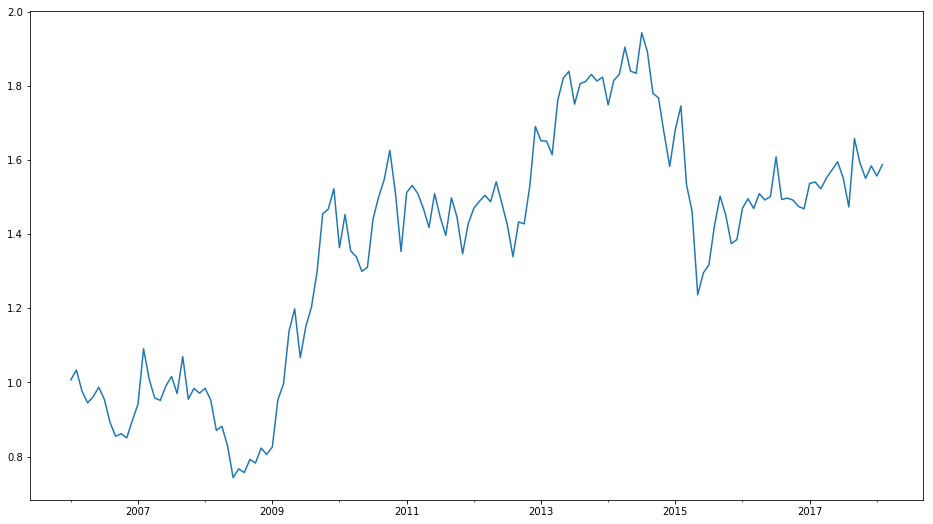

In [263]:
nav = (1+acc_ret).cumprod()
nav.plot(figsize=(16, 9))

In [281]:
pred_y = pd.Series(index=acc_ret.index)
window = 36
for date in fea.index:
    past_fea = fea[fea.index < date].iloc[-window:]
    past_ret = acc_ret[acc_ret.index < date].iloc[-window:]
    if past_fea.shape[0] == window:
        lasso = linear_model.Lasso(alpha=0.005)
        lasso.fit(past_fea, past_ret)
#         print lasso.coef_.sum()
        pred_y.loc[date] = lasso.predict([fea.loc[date]])[0]

In [282]:
ldf.loc[past_fea.columns[lasso.coef_ != 0]]

,名称
代码,
M0000622,CPI-鲜菜
M0009973,月度新增人民币贷款
S0048337,发电累计耗用原煤
S5808573,LME锌三个月期货价格
S0049493,上交所铜库存
S0049494,上交所铝库存
M0067855,人民币汇率


train accuracy: 0.00241267775175
test accuracy: 0.0435141327899


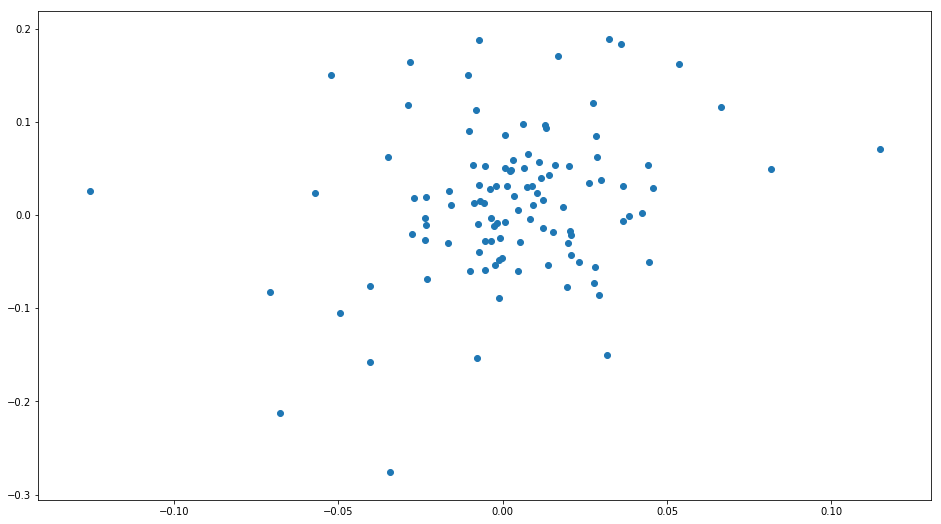

In [284]:
plt.figure(figsize=(16, 9))
# plt.scatter(pred_y, rdf['881001.WI'])
plt.scatter(pred_y.shift(1), rdf['881001.WI'])
print 'train accuracy:', pred_y.corr(acc_ret)
print 'test accuracy:', pred_y.shift(1).corr(acc_ret)

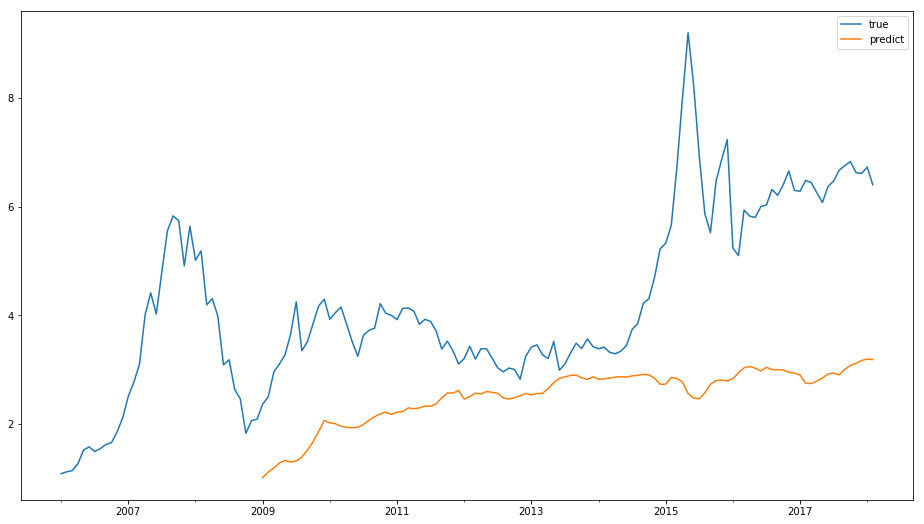

In [280]:
(1 + rdf['881001.WI']).cumprod().plot(figsize=(16, 9), label='true')
(1 + pred_y).cumprod().plot(figsize=(16, 9), label='predict')
plt.legend()

# 三分类

In [401]:
code = '886033.WI'
acc_ret = rdf[code] - rdf['881001.WI']
acc_ret.shift(1).corr(acc_ret)

-0.033668245322059462

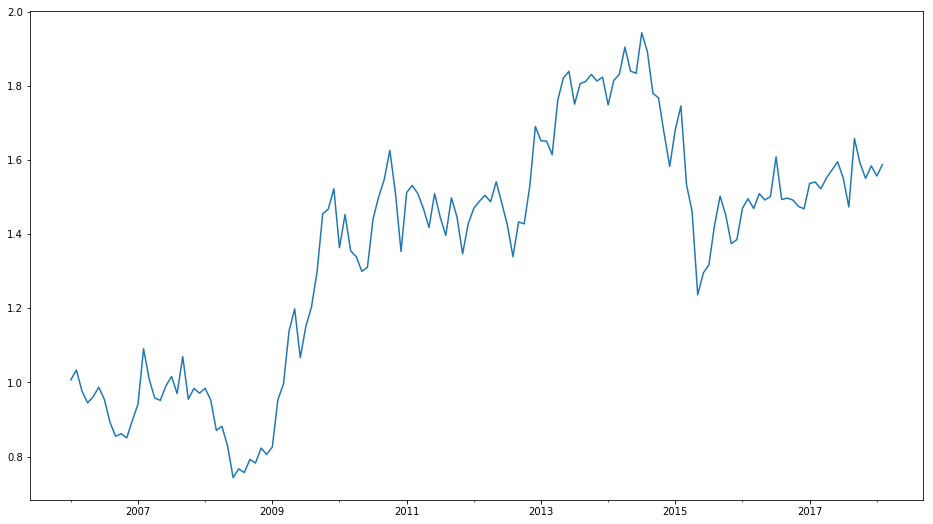

In [402]:
nav = (1+acc_ret).cumprod()
nav.plot(figsize=(16, 9))

In [403]:
quant = acc_ret.quantile([1./3, 2./3])

In [404]:
quant

0.333333   -0.017489
0.666667    0.026524
dtype: float64

In [405]:
y = acc_ret.copy()
y[y < quant.iloc[0]] = -1
y[(y >= quant.iloc[0]) & (y < quant.iloc[1])] = 0
y[y > quant.iloc[1]] = 1

In [406]:
fea.shape, acc_ret.shape

((146, 114), (146L,))

In [415]:
# clf = ensemble.AdaBoostClassifier(learning_rate=0.01)
clf = svm.SVC(C=1)
clf.fit(fea, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [416]:
# ldf.loc[fea.columns[clf.feature_importances_ != 0]]

In [417]:
scores = cross_val_score(clf, fea, y, cv=10)

In [418]:
scores.mean()

0.18714285714285714